In [1]:
import os, json, torch

# base_image_path = r'D:\\Master_Thesis_data\\Active_Speaker\\data\\test\\images\\'
target_json_paths = r'D:\\Master_Thesis_data\\Active_Speaker_overlapped\\data\\test'
result_json_paths = r"D:\Master-Thesis_results_all\Pix2Pix\Active_Speaker-overlapped"
# output_path = r'D:\Master-Thesis_results_all\SAN\persons\test\plotted_dall-e\\'
target_file_name = 'result.json'

for foldername, subfolders, filenames in os.walk(result_json_paths):
    if target_file_name in filenames:
        file_path = os.path.join(foldername, target_file_name)
        with open(file_path, "r") as file:
            if not "data_result" in vars():
                data_result = json.load(file)
            else:
                raise ValueError(f"data_result already used")

for foldername, subfolders, filenames in os.walk(target_json_paths):
    if target_file_name in filenames:
        file_path = os.path.join(foldername, target_file_name)
        with open(file_path, "r") as file:
            if not "data_target" in vars():
                data_target = json.load(file)
            else:
                raise ValueError(f"data_result already used")

In [2]:
def get_final_dict_from_annotations(json_data):
    transform = False
    
    for value in json_data["annotations"][:100]:
        x, y, x_end, y_end = value["bbox"]
        if x_end < x or y_end < y:
            transform = True
            break
            
    json_data["images"][0]["width"]
    json_data["images"][0]["width"]
    data_target_images = {i["id"]: ["-".join(i["file_name"].replace("images\\", "").replace("_fake_B", "").replace("_test", "").replace(".jpg", "").replace(".png", "").split("-")[-1:]), i["width"], i["height"]] for i in json_data["images"]}
    if transform is False:
        return {data_target_images[i["image_id"]][0]: [i["bbox"], data_target_images[i["image_id"]][1], data_target_images[i["image_id"]][2]] for i in json_data["annotations"]}
    else:
        return {data_target_images[i["image_id"]][0]: [[i["bbox"][0], i["bbox"][1], i["bbox"][0] + i["bbox"][2], i["bbox"][1] + i["bbox"][3]], data_target_images[i["image_id"]][1], data_target_images[i["image_id"]][2]] for i in json_data["annotations"]}
    
# Function to calculate the area of a bounding box
def calculate_area(bbox):
    if bbox is not None:
        if isinstance(bbox[0], list):
            bbox_temp = bbox[0]
        else:
            bbox_temp = bbox
        
        x_start, y_start, x_end, y_end = bbox_temp
        width = x_end - x_start
        height = y_end - y_start
        area = width * height
        return area
    else:
        raise ValueError("Invalid bbox value has been passed!")
        
def bbox_iou(box1: float, box2: float, return_intersection_area: bool =False, return_intersection_area_as_bbox: bool =False):
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    intersection_area = max(x_max - x_min, 0) * max(y_max - y_min, 0)
    union_area = area1 + area2 - intersection_area

    iou = intersection_area / union_area
    
    return_value = iou
    if return_intersection_area:
        if not isinstance(return_value, list):
            return_value = [return_value]
        return_value.append(intersection_area)
    if return_intersection_area_as_bbox:
        if not isinstance(return_value, list):
            return_value = [return_value]
        return_value.append([x_min, y_min, x_max, y_max])

    return return_value

def voting_function(boxes, iou_threshold = 0.5):
    n = len(boxes)
    
    assert n == 3, "Please provide list of bboxes with length 3"

    if n < 2:
        return 0, 0, 0, 0  # Not enough bounding boxes for voting

    max_vote_area = 0
    max_vote_box = (0, 0, 0, 0)

    for i in range(n - 1):
        for j in range(i + 1, n):
            iou, intersection_area, intersection_bbox = bbox_iou(boxes[i], boxes[j], return_intersection_area=True, return_intersection_area_as_bbox=True)

            if iou >= iou_threshold:
                # Consider the area covered by at least 2 overlapping bounding boxes
                vote_area = intersection_area
                #max((boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]),
                                #(boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]))

                if vote_area > max_vote_area:
                    max_vote_area = vote_area
                    #x_start = min(boxes[i][0], boxes[j][0])
                    #y_start = min(boxes[i][1], boxes[j][1])
                    #x_end = max(boxes[i][2], boxes[j][2])
                    #y_end = max(boxes[i][3], boxes[j][3])
                    max_vote_box = intersection_bbox
    
    if torch.is_tensor(max_vote_box[0]):
        max_vote_box = list(map(int, max_vote_box))
    return max_vote_box

def prepare_voting_dict(pdict: dict, threshold: 0.5) -> dict:
    temp_result_dict = {}
    for k,v in pdict.items():
        temp_key = k.replace("_0", "").replace("_1", "").replace("_2", "")
        if temp_key in temp_result_dict:
            temp_result_dict[temp_key][0].append(v[0])
        else:
            temp_list = [[v[0]], v[1], v[2]]
            temp_result_dict[temp_key] = temp_list

    temp_result_dict = {k: [voting_function(v[0], threshold), v[1], v[2]] for k,v in temp_result_dict.items()}
    
    return temp_result_dict
    
    

In [5]:
data_result_images = get_final_dict_from_annotations(data_result)
data_target_images = get_final_dict_from_annotations(data_target)

In [6]:
false_negative = 0
true_negative = 0
false_positive = 0
true_positive = 0
area_and_iou_comparison = True
iou_comparison = 0.5
voting = False

if voting:
    data_result_images = prepare_voting_dict(data_result_images, iou_comparison)

for k, v in data_target_images.items():
    target_bbox, target_width, target_height = v
    result_bbox, result_width, result_height = data_result_images[k]
    
    
    if target_width > result_width or target_height > target_height:
        x, y, x_end, y_end = target_bbox
        
        x = x * (result_width / target_width)
        x_end = x_end * (result_width / target_width)
        
        y = y * (result_width / target_width)
        y_end = y_end * (result_width / target_width)
        
        target_bbox = [x, y, x_end, y_end]        
    
    #print(k)
    #print(target_bbox)
    #print(result_bbox)
    if k in data_result_images:
        if area_and_iou_comparison:
            max_allowed_area = 1.3 * calculate_area(target_bbox)
            min_allowed_area = 0.7 * calculate_area(target_bbox)
            actual_area = calculate_area(target_bbox)
            #print(max_allowed_area)
            #print(actual_area)
        p_bbox_iou = bbox_iou(target_bbox, result_bbox)
        #print(p_bbox_iou)
        
        if (p_bbox_iou > 0 and area_and_iou_comparison is False) or (p_bbox_iou >= iou_comparison and min_allowed_area <= actual_area and area_and_iou_comparison and max_allowed_area >= actual_area):
            true_positive += 1
        else:
#             if min_allowed_area > actual_area:
#                 print("area to small")
#             if max_allowed_area < actual_area:
#                 print("area to big")
#             if p_bbox_iou <= 0:
#                 print(p_bbox_iou)
            
            false_positive += 1
    else:
        print(f"k: {k} not in data_result_images")
        false_negative += 1
    
print(f"true_positive: {true_positive}")
print(f"false_positive: {false_positive}")
print(f"false_negative: {false_negative}")
print(f"true_negative: {true_negative}")
print({"precision": true_positive / max((true_positive + false_positive), 0.1),
            "recall": true_positive / max((true_positive + false_negative), 0.1)})

true_positive: 0
false_positive: 230
false_negative: 0
true_negative: 0
{'precision': 0.0, 'recall': 0.0}


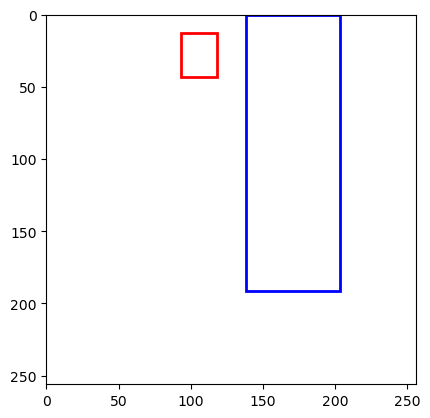

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Bounding boxes
box1 = [93.39223153084541, 12.478293983244477, 117.95887281035795, 42.8941355674029]
box2 = [138.12093023255815, 0.0, 203.37116279069767, 191.70232558139534]

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the first bounding box
rect1 = patches.Rectangle((box1[0], box1[1]), box1[2] - box1[0], box1[3] - box1[1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)

# Display the second bounding box
rect2 = patches.Rectangle((box2[0], box2[1]), box2[2] - box2[0], box2[3] - box2[1], linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect2)

# Set the aspect of the plot to be equal
ax.set_aspect('equal', adjustable='box')

# Set the axis limits based on bounding boxes
ax.set_xlim(0, 256)
ax.set_ylim(0, 256)

ax.invert_yaxis()

# Show the plot
plt.show()


In [1]:
# Code to extract result files from all files

import os
import shutil

source_folder = r'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\images'
destination_folder = r'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Loop through files in the source folder
for filename in os.listdir(source_folder):
    # Check if the filename contains "_fake_B"
    if "_fake_B" in filename:
        # Create the full paths for the source and destination
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)

        # Copy the file to the destination folder
        shutil.copy2(source_path, destination_path)
        print(f"File '{filename}' copied to '{destination_folder}'.")


File '2250_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2250_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2250_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2251_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2251_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2251_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File

File '2273_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2273_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2273_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2274_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2274_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2274_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File

File '2296_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2296_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2296_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2297_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2297_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2297_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File

File '2320_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2321_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2321_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2321_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2322_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2322_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File

File '2343_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2344_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2344_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2344_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2345_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2345_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File

File '2366_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2366_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2367_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2367_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2367_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2368_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File

File '2389_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2389_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2390_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2390_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2390_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2391_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File

File '2411_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2412_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2412_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2412_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2413_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2413_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File

File '2436_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2436_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2437_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2437_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2437_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2438_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File

File '2460_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2460_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2461_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2461_1_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2461_2_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File '2462_0_fake_B.png' copied to 'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_active_speaker_persons\test_12\results_only'.
File